In [1]:
import math
import random
import copy
import numpy as np
import matplotlib.pyplot as plt

# equations
def parabula(x):
    return x[0]**2 - x[1]

def linear(x):
    return x[0] - x[1]

# mutation

def mutation(generation, features, feature_range, number_of_mutations, vis_key = False):
    # if we want visualise make new array for visualise
    if vis_key == True:
        features_for_vis = copy.deepcopy(features)
    # take id of mutants
    mutants = random.sample(generation, number_of_mutations)
    # add new mutant skill
    for mutant_id in mutants:
        # where to change
        skill_id = random.sample(range(len(features[mutant_id])), 1)[0]
        # what to change
        new_skill = random.sample(feature_range, 1)
        if vis_key == True:
            features_for_vis[mutant_id][skill_id] = new_skill
        features[mutant_id][skill_id] = new_skill[0]
    if vis_key == True:
        return features, features_for_vis
    return features

# reproduction

# sigmoid to make + prob bigger
def sigmoid_plus(x):
    try:
        #math domain error fix
        shift = 1
        #---------------------
        x = math.log10(x + shift) if x > 0 else -math.log10(abs(x) + shift)
        result = 1 / (1 + math.exp(x))
    except OverflowError:
        result = 0
    return result

# sigmoid to make - prob bigger
def sigmoid_minus(x):
    try:
        #math domain error fix
        shift = 1
        #---------------------
        x = math.log10(x + shift) if x > 0 else -math.log10(abs(x) + shift)
        result = 1 / (1 + math.exp(-x))
    except OverflowError:
        result = 0
    return result

def count_probs_to_take_feature(generation, find_max):
    # alpha to except division by 0 
    alpha = 0.000000000000000000001
    if find_max == True:
        coefficient_to_survive = list(map(lambda i: 1 / (sigmoid_plus(i) + alpha), generation))
    else:
        coefficient_to_survive = list(map(lambda i: 1 / (sigmoid_minus(i) + alpha), generation))
    sum_of_probs_to_survive = np.sum(coefficient_to_survive)
    # make prob to be taken
    probs = list(map(lambda i: i / sum_of_probs_to_survive, coefficient_to_survive))
    return probs


def make_child(father, mother, vis_key):
    # barrier to split features
    alpha = random.sample(range(int(len(father) / 2)), 1)[0]
    alpha = -alpha % len(father)
    child = father[:alpha] + mother[alpha:]
    if vis_key == True:
        vis_child = [father[:alpha]], mother[alpha:]
        return child, vis_child
    return child


def reproduction(generation_results, features, num_of_children, vis_key=False, find_max = True):
    
    # discard the same results, because they will affect to prob
    generation_results, index = np.unique(generation_results, return_index=True)
    features = [features[i] for i in index]

    new_generation_features = []
    vis_new_generation_features = []

    for child_id in range(num_of_children):
        # take father and mother with the best features
        probs = count_probs_to_take_feature(generation_results, find_max)
        father_id = np.random.choice(range(len(generation_results)), p=probs)
        mother_id = np.random.choice(range(len(generation_results)), p=probs)

        if vis_key == True:
            child, vis_child = make_child(features[father_id], features[mother_id], vis_key)
            vis_new_generation_features.append(vis_child)
        else:
            child = make_child(features[father_id], features[mother_id], vis_key)
        new_generation_features.append(child)
    if vis_key == True:
        return new_generation_features, vis_new_generation_features
    return new_generation_features

# evaluate

def evaluate(features, function):
    generation_results = []
    for feature in features:
        generation_results.append(function(feature))
    return generation_results

# run genetic algorithm

def run_genetic_algorithm(features, function, feature_range, num_of_children, speed_parameter, year, find_max):
    generation_results = evaluate(features, function)
    generation_ids = range(len(generation_results))
    if year % speed_parameter == 0:
        # make mutation
        number_of_mutations = random.sample(range(int(len(generation_results) / 10 + 1)), 1)[0]
        features = mutation(generation_ids, copy.deepcopy(features), feature_range, number_of_mutations)
        generation_results = evaluate(features, function)
    # get new features
    features = reproduction(generation_results, features, num_of_children, find_max = find_max)
    return features

# plot history

def plot(History):
    fig = plt.figure()

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
    ax.set_xlabel('year')
    ax.set_ylabel('value')

    # Create a legend for the first line.
    line1, = plt.plot(range(len(History)), History, label="agent", linestyle='--')

    first_legend = plt.legend(handles=[line1], loc=1)
    # Add the legend manually to the current Axes.
    ax = plt.gca().add_artist(first_legend)
    plt.show()

/home/artem/anaconda3/envs/pixor_tmp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:

def find_max():
    features = [[10, 4], [14, 21], [10, 1], [14, 10], [10, 40]]

    function = parabula
    init_results = np.average(evaluate(features, function))
    print(evaluate(features, function))
    print('init results: ', init_results)

    life_time = 1000
    old_generation_results = init_results
    feature_range = range(-40, 40)
    num_of_children = 10
    barrier = 10
    #speed_parameter = int(life_time / 50)
    speed_parameter = 10
    History = []

    find_max = True
    for year in range(life_time):
        # print(year)
        features = run_genetic_algorithm(features, function, feature_range, num_of_children, speed_parameter, year, find_max)
        old_generation_results = evaluate(features, function)
        result = np.average(old_generation_results)
        History.append(result)

    print('done!')
    print('final result', np.average(old_generation_results))

    plot(History)


def find_min():

    features = [[10, 4], [14, 21], [10, 1], [14, 10], [10, 40]]

    function = parabula
    init_results = np.average(evaluate(features, function))
    print(evaluate(features, function))
    print('init results: ', init_results)

    life_time = 1000
    old_generation_results = init_results
    feature_range = range(-40, 40)
    num_of_children = 10
    barrier = 10
    #speed_parameter = int(life_time / 50)
    speed_parameter = 10
    History = []

    find_max = False
    for year in range(life_time):
        # print(year)
        features = run_genetic_algorithm(features, function, feature_range, num_of_children, speed_parameter, year, find_max = find_max)
        old_generation_results = evaluate(features, function)
        result = np.average(old_generation_results)
        History.append(result)

    print('done!')
    print('final result', np.average(old_generation_results))

    plot(History)

[96, 175, 99, 186, 60]
init results:  123.2
done!
final result -29.5


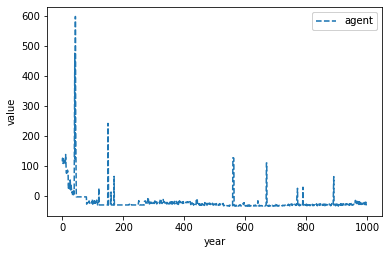

In [6]:
find_min()

[96, 175, 99, 186, 60]
init results:  123.2
done!
final result 1181.8


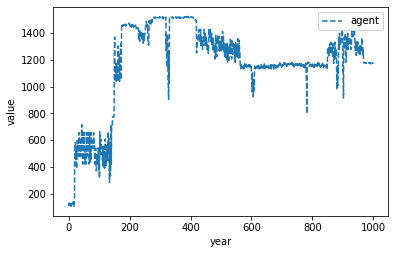

In [7]:
find_max()